# Strawberry Counting: From Baseline to Fine-Tuned YOLO

This notebook demonstrates a complete workflow for building an object counter, starting from a simple baseline model and progressing to a fine-tuned YOLOv11 model.

We will cover:
1.  **Dataset Preparation**: Splitting and formatting our strawberry image data.
2.  **Baseline Model**: Using OpenCV Template Matching for a quick and simple count.
3.  **Pre-trained YOLO**: Testing a generic, off-the-shelf YOLO model.
4.  **Fine-Tuning YOLO**: Training the YOLO model on our specific strawberry data.
5.  **Evaluation**: Comparing the results from the fine-tuned model.

In [1]:
import os
import sys
import cv2
import matplotlib.pyplot as plt

# Add src directory to path to import our custom modules
sys.path.append(os.path.abspath('src'))

# --- Configuration ---
# Define all the paths we will need
CWD = os.getcwd()
XML_PATH = os.path.join(CWD, 'dataset', 'annotations.xml')
IMAGES_DIR = os.path.join(CWD, 'dataset', 'images')
YOLO_DATASET_DIR = os.path.join(CWD, 'strawberry_dataset')
TEMPLATE_PATH = os.path.join(CWD, 'template', 'template.png')
BASELINE_OUT = os.path.join(CWD, 'output', 'baseline_result.png')
PRETRAINED_MODEL = 'yolo11s.pt'
FINETUNED_OUT_DIR = os.path.join(CWD, 'output', 'finetuned_preds')
PRETRAINED_OUT_DIR = os.path.join(CWD, 'output', 'pretrained_preds')

# Ensure output directories exist
os.makedirs('output', exist_ok=True)
os.makedirs('template', exist_ok=True)

## 1. Data Preparation

First, we need to prepare our dataset. The source data is a collection of images with a single XML file containing all annotations. We will split this into training and validation sets and convert the annotations to the YOLO `.txt` format that the model requires.

Our `split_and_prepare` function in `src/yolo_utils.py` handles this entire process.

In [2]:
from yolo_utils import split_and_prepare

print("Splitting data and creating YOLO-formatted dataset...")
split_and_prepare(XML_PATH, IMAGES_DIR, YOLO_DATASET_DIR)
print(f"Dataset successfully created at: {YOLO_DATASET_DIR}")

Splitting data and creating YOLO-formatted dataset...
Dataset successfully created at: c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset


## 2. Baseline Model: OpenCV Template Matching

Before diving into deep learning, we'll establish a baseline using a simple computer vision technique: template matching. This method works by sliding a "template" image (a small, cropped-out image of a strawberry) across a larger image to find matches.

It's fast but often struggles with variations in scale, rotation, and lighting.

Creating template from image 0...


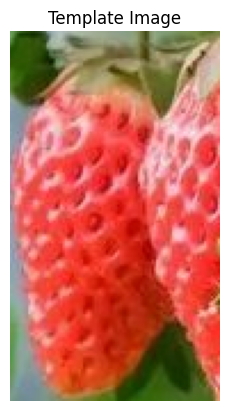

In [3]:
from baseline import create_template, run_baseline

# First, create a template from our dataset
print("Creating template from image 0...")
create_template(XML_PATH, IMAGES_DIR, TEMPLATE_PATH)

# Display the template
template_img = cv2.imread(TEMPLATE_PATH)
plt.imshow(cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB))
plt.title("Template Image")
plt.axis('off')
plt.show()

Running baseline detection on c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\dataset\images\1.png...
Baseline - Found 0 items.


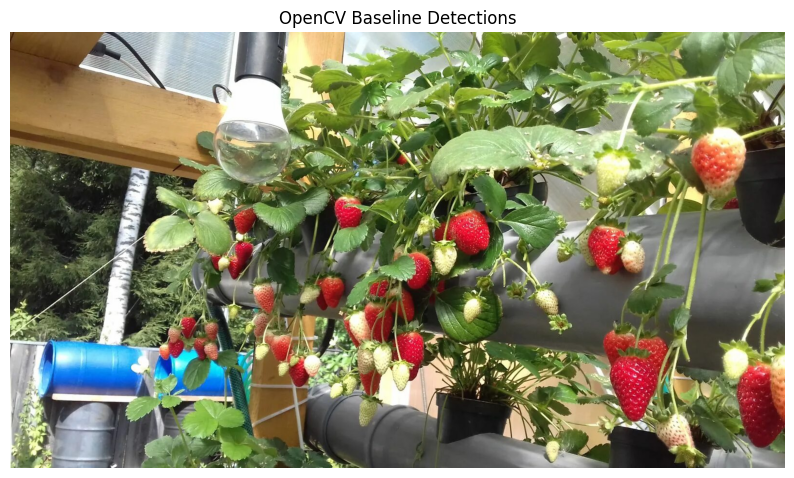

In [4]:
# Run the baseline model on a sample image
sample_image_path = os.path.join(IMAGES_DIR, '1.png')
print(f"Running baseline detection on {sample_image_path}...")
run_baseline(sample_image_path, TEMPLATE_PATH, BASELINE_OUT)

# Display the result
baseline_result = cv2.imread(BASELINE_OUT)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(baseline_result, cv2.COLOR_BGR2RGB))
plt.title("OpenCV Baseline Detections")
plt.axis('off')
plt.show()

## 3. Pre-trained YOLOv11 Inference

Now, let's see how a powerful, pre-trained YOLOv11 model performs without any specific training on our strawberries. This model has been trained on the large COCO dataset and can recognize 80 common object classes, but "strawberry" is not one of them. We are testing its ability to generalize.

Running pre-trained YOLOv11 inference on images in c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val...


100%|██████████| 18.4M/18.4M [00:04<00:00, 4.46MB/s]



image 1/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val\1.png: 384x640 8 apples, 3 potted plants, 131.7ms
image 2/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val\13.png: 512x640 2 apples, 1 potted plant, 124.7ms
image 3/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val\14.png: 480x640 1 surfboard, 1 knife, 2 broccolis, 1 chair, 114.5ms
image 4/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val\15.png: 480x640 3 apples, 1 orange, 1 potted plant, 101.9ms
image 5/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val\16.png: 448x640 12 apples, 3 broccolis, 125.0ms
image 6/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val\21.png: 480x640 1 broccoli, 1 potted plant, 114.2ms
image 7/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Ob

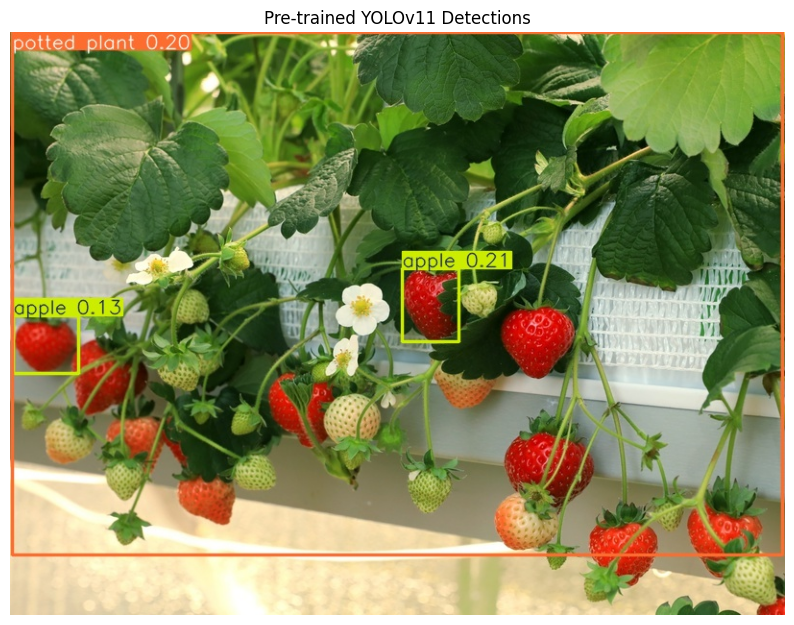

In [5]:
from train_and_infer import run_inference

# Run inference with the pre-trained model
val_dir = os.path.join(YOLO_DATASET_DIR, 'images', 'val')
print(f"Running pre-trained YOLOv11 inference on images in {val_dir}...")
run_inference(PRETRAINED_MODEL, val_dir, PRETRAINED_OUT_DIR, conf=0.1)

# Display a sample result
# Note: The output path is nested due to the project/name structure of YOLO's predict function
pretrained_result_path = os.path.join(PRETRAINED_OUT_DIR, 'predictions', '13.jpg') 

# Check if the result file was created
if os.path.exists(pretrained_result_path):
    pretrained_result = cv2.imread(pretrained_result_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(pretrained_result, cv2.COLOR_BGR2RGB))
    plt.title("Pre-trained YOLOv11 Detections")
    plt.axis('off')
    plt.show()
else:
    print(f"Could not find result file at {pretrained_result_path}")
    print("This is expected, as the pre-trained model does not know how to detect strawberries.")

## 4. Fine-Tuning the YOLOv11 Model

The pre-trained model likely performed poorly because it hasn't been taught to recognize our specific strawberries. Now, we will fine-tune it. We take the pre-trained model and train it further on our labeled strawberry dataset. This teaches the model to become an expert at finding ripe strawberries.

**Note**: Training can take a significant amount of time, depending on your hardware (a GPU is highly recommended). We'll run it for just 25 epochs here as a demonstration. For best results, 100+ epochs are recommended.

In [6]:
from train_and_infer import train_model

data_yaml_path = os.path.join(YOLO_DATASET_DIR, 'data.yaml')

print("Starting YOLOv11 model training...")
# For demonstration, we use a smaller number of epochs.
# Increase to 100 or more for better performance.
# We increase the epochs here for better results. If you have a GPU, change 'cpu' to 'cuda'.
weights_path = train_model(data_yaml_path, epochs=200, device='cpu') 
print(f"Training complete. Best weights saved at: {weights_path}")

Starting YOLOv11 model training...
Ultralytics 8.3.158  Python-3.12.9 torch-2.7.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimi

train: Scanning C:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\labels\train... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<00:00, 698.88it/s]

train: New cache created: C:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\labels\train.cache
val: Fast image access  (ping: 0.00.0 ms, read: 3075.6422.0 MB/s, size: 1166.6 KB)



c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\labels\val... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 1885.19it/s]

val: New cache created: C:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\labels\val.cache



c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to output\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to output\train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200         0G      2.097      2.746      1.832        469        640: 100%|██████████| 2/2 [00:25<00:00, 12.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

                   all          8         79      0.319      0.215      0.194     0.0754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200         0G      1.952      2.385      1.814        344        640: 100%|██████████| 2/2 [00:21<00:00, 10.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all          8         79       0.38      0.405      0.331      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200         0G      1.707      2.133      1.745        302        640: 100%|██████████| 2/2 [00:20<00:00, 10.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all          8         79      0.415      0.557      0.432      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200         0G      1.599      1.785      1.595        286        640: 100%|██████████| 2/2 [00:22<00:00, 11.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

                   all          8         79      0.625      0.722      0.648      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200         0G      1.493      1.693      1.509        323        640: 100%|██████████| 2/2 [00:20<00:00, 10.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all          8         79      0.529      0.782        0.7      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200         0G      1.513      1.459      1.458        346        640: 100%|██████████| 2/2 [00:20<00:00, 10.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all          8         79      0.622      0.792      0.721       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200         0G      1.391      1.137      1.278        446        640: 100%|██████████| 2/2 [00:19<00:00,  9.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all          8         79      0.623      0.734        0.7      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200         0G      1.432       1.12      1.275        347        640: 100%|██████████| 2/2 [00:19<00:00,  9.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                   all          8         79      0.662      0.759       0.72      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200         0G      1.451      1.239      1.272        236        640: 100%|██████████| 2/2 [00:20<00:00, 10.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

                   all          8         79       0.65      0.684      0.665      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200         0G      1.507      1.232      1.252        371        640: 100%|██████████| 2/2 [00:19<00:00,  9.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all          8         79      0.789       0.57       0.67      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200         0G      1.324      1.118      1.198        276        640: 100%|██████████| 2/2 [00:19<00:00,  9.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all          8         79      0.797      0.595      0.722      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200         0G      1.309      1.006      1.212        436        640: 100%|██████████| 2/2 [00:20<00:00, 10.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all          8         79      0.797      0.734      0.796      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200         0G      1.237      0.944      1.168        389        640: 100%|██████████| 2/2 [00:19<00:00,  9.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all          8         79      0.798        0.8      0.793      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200         0G      1.246      1.008      1.212        292        640: 100%|██████████| 2/2 [00:20<00:00, 10.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all          8         79      0.799      0.756       0.82      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200         0G      1.249     0.9842      1.154        331        640: 100%|██████████| 2/2 [00:20<00:00, 10.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all          8         79      0.735      0.737      0.783      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200         0G      1.195      0.964      1.137        301        640: 100%|██████████| 2/2 [00:19<00:00,  9.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

                   all          8         79      0.674      0.722      0.723      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200         0G      1.172     0.9149      1.114        290        640: 100%|██████████| 2/2 [00:20<00:00, 10.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

                   all          8         79      0.711      0.734      0.774      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200         0G      1.101     0.8341      1.102        352        640: 100%|██████████| 2/2 [00:20<00:00, 10.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all          8         79      0.717      0.785      0.797      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200         0G      1.125     0.9243      1.128        416        640: 100%|██████████| 2/2 [00:19<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

                   all          8         79      0.788      0.707      0.806      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200         0G      1.031     0.7843      1.105        281        640: 100%|██████████| 2/2 [00:20<00:00, 10.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all          8         79      0.775      0.696      0.797      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200         0G      1.124      0.818      1.115        385        640: 100%|██████████| 2/2 [00:19<00:00,  9.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all          8         79      0.779      0.849      0.865      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200         0G      1.255     0.8736      1.157        321        640: 100%|██████████| 2/2 [00:19<00:00,  9.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

                   all          8         79      0.689      0.871      0.798      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200         0G      1.097     0.7565      1.075        322        640: 100%|██████████| 2/2 [00:20<00:00, 10.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

                   all          8         79      0.715        0.7      0.753      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200         0G      1.156      0.843      1.111        245        640: 100%|██████████| 2/2 [00:20<00:00, 10.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

                   all          8         79      0.674      0.863      0.833      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200         0G      1.176     0.8099      1.119        342        640: 100%|██████████| 2/2 [00:20<00:00, 10.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all          8         79      0.798      0.671      0.785      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200         0G      1.183     0.8132       1.08        357        640: 100%|██████████| 2/2 [00:20<00:00, 10.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

                   all          8         79      0.822      0.684      0.781      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200         0G       1.12     0.8055       1.07        354        640: 100%|██████████| 2/2 [00:19<00:00,  9.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

                   all          8         79      0.838      0.797      0.835      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200         0G      1.183      0.751      1.127        356        640: 100%|██████████| 2/2 [00:20<00:00, 10.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all          8         79      0.838      0.797      0.835      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200         0G      1.219     0.8455      1.177        320        640: 100%|██████████| 2/2 [00:19<00:00,  9.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

                   all          8         79      0.876      0.747       0.85      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200         0G      1.059     0.7307      1.111        308        640: 100%|██████████| 2/2 [00:19<00:00,  9.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

                   all          8         79      0.798      0.698      0.791      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200         0G      1.088     0.7336       1.11        242        640: 100%|██████████| 2/2 [00:20<00:00, 10.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all          8         79      0.798      0.698      0.791      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200         0G      1.165     0.7715      1.092        348        640: 100%|██████████| 2/2 [00:19<00:00,  9.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all          8         79      0.715      0.698      0.738      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200         0G      1.001     0.7843      1.038        328        640: 100%|██████████| 2/2 [00:19<00:00,  9.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

                   all          8         79      0.772      0.671      0.753      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200         0G      1.091     0.7116      1.057        389        640: 100%|██████████| 2/2 [00:19<00:00,  9.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

                   all          8         79      0.772      0.671      0.753      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200         0G     0.9508     0.6969      1.037        289        640: 100%|██████████| 2/2 [00:19<00:00,  9.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all          8         79      0.765      0.699      0.733       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200         0G     0.9764     0.6724      1.013        444        640: 100%|██████████| 2/2 [00:20<00:00, 10.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all          8         79      0.931      0.683      0.798      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200         0G     0.9888      0.658      1.021        325        640: 100%|██████████| 2/2 [00:19<00:00,  9.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all          8         79      0.931      0.683      0.798      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200         0G     0.9154     0.6813      1.035        313        640: 100%|██████████| 2/2 [00:19<00:00,  9.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all          8         79      0.782       0.68      0.756      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200         0G      1.015     0.7424      1.024        412        640: 100%|██████████| 2/2 [00:20<00:00, 10.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

                   all          8         79      0.774      0.709      0.773      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200         0G     0.9605      0.651      1.026        342        640: 100%|██████████| 2/2 [00:19<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all          8         79      0.774      0.709      0.773      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200         0G       1.01     0.6706     0.9936        352        640: 100%|██████████| 2/2 [00:19<00:00,  9.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

                   all          8         79      0.894      0.671      0.776      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200         0G     0.9684     0.6428      1.015        346        640: 100%|██████████| 2/2 [00:20<00:00, 10.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

                   all          8         79      0.844      0.734      0.814      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200         0G     0.9436     0.6246     0.9868        356        640: 100%|██████████| 2/2 [00:19<00:00,  9.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all          8         79      0.844      0.734      0.814      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200         0G     0.9202     0.6389      0.998        293        640: 100%|██████████| 2/2 [00:19<00:00,  9.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

                   all          8         79      0.914      0.696      0.809      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200         0G     0.8513     0.5719     0.9797        293        640: 100%|██████████| 2/2 [00:20<00:00, 10.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

                   all          8         79      0.914      0.696      0.809      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200         0G     0.8797      0.586     0.9819        350        640: 100%|██████████| 2/2 [00:19<00:00,  9.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all          8         79      0.872      0.646      0.779      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200         0G      1.007     0.6616       1.01        471        640: 100%|██████████| 2/2 [00:20<00:00, 10.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

                   all          8         79      0.872      0.646      0.779      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200         0G     0.9349     0.6098     0.9863        259        640: 100%|██████████| 2/2 [00:19<00:00,  9.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all          8         79      0.821      0.697      0.831      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200         0G     0.9502     0.6285      1.022        374        640: 100%|██████████| 2/2 [00:19<00:00,  9.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all          8         79      0.821      0.697      0.831      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200         0G     0.9449       0.61      1.031        263        640: 100%|██████████| 2/2 [00:20<00:00, 10.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all          8         79      0.805      0.731      0.784      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200         0G      0.946     0.6128      1.005        303        640: 100%|██████████| 2/2 [00:19<00:00,  9.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all          8         79      0.805      0.731      0.784      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200         0G      0.965     0.6371      1.022        211        640: 100%|██████████| 2/2 [00:19<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all          8         79      0.814      0.718      0.762      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200         0G     0.9805     0.6215      1.023        295        640: 100%|██████████| 2/2 [00:20<00:00, 10.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all          8         79      0.814      0.718      0.762      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200         0G     0.9753     0.6438      1.022        496        640: 100%|██████████| 2/2 [00:19<00:00,  9.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all          8         79      0.838       0.72      0.796      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200         0G     0.8576     0.5903     0.9899        349        640: 100%|██████████| 2/2 [00:19<00:00,  9.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

                   all          8         79      0.838       0.72      0.796      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200         0G     0.8645      0.598     0.9848        316        640: 100%|██████████| 2/2 [00:20<00:00, 10.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all          8         79      0.834      0.722      0.791       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200         0G      0.986     0.5699     0.9858        389        640: 100%|██████████| 2/2 [00:19<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all          8         79      0.834      0.722      0.791       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200         0G      1.014     0.6089      1.041        237        640: 100%|██████████| 2/2 [00:19<00:00,  9.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all          8         79      0.766      0.772      0.828      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200         0G     0.8998     0.5909     0.9586        402        640: 100%|██████████| 2/2 [00:22<00:00, 11.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          8         79      0.766      0.772      0.828      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200         0G     0.8579     0.5773     0.9816        264        640: 100%|██████████| 2/2 [00:19<00:00,  9.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all          8         79      0.746      0.772      0.846      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200         0G     0.8798     0.5616     0.9439        409        640: 100%|██████████| 2/2 [00:19<00:00,  9.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.746      0.772      0.846      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200         0G     0.8868     0.5702     0.9662        439        640: 100%|██████████| 2/2 [00:19<00:00,  9.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all          8         79      0.793       0.81      0.843       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200         0G     0.9133     0.5873     0.9873        350        640: 100%|██████████| 2/2 [00:19<00:00,  9.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          8         79      0.793       0.81      0.843       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200         0G     0.8314     0.5567      0.969        297        640: 100%|██████████| 2/2 [00:19<00:00,  9.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all          8         79      0.837      0.747      0.817      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200         0G     0.8797     0.5531     0.9678        327        640: 100%|██████████| 2/2 [00:19<00:00,  9.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all          8         79      0.837      0.747      0.817      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200         0G     0.8395     0.5414     0.9485        392        640: 100%|██████████| 2/2 [00:19<00:00,  9.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          8         79      0.832      0.691      0.773      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200         0G     0.8117     0.5447      0.967        334        640: 100%|██████████| 2/2 [00:19<00:00,  9.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all          8         79      0.832      0.691      0.773      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200         0G     0.7885     0.5219     0.9446        270        640: 100%|██████████| 2/2 [00:19<00:00,  9.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.832      0.709      0.769      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200         0G       0.86      0.546     0.9531        286        640: 100%|██████████| 2/2 [00:19<00:00,  9.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all          8         79      0.832      0.709      0.769      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200         0G     0.7884      0.521     0.9457        366        640: 100%|██████████| 2/2 [00:20<00:00, 10.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          8         79      0.904      0.734      0.819      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200         0G     0.8001     0.5434     0.9395        246        640: 100%|██████████| 2/2 [00:19<00:00,  9.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          8         79      0.904      0.734      0.819      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200         0G      0.757     0.5178     0.9451        265        640: 100%|██████████| 2/2 [00:20<00:00, 10.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all          8         79       0.88      0.759      0.816      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200         0G     0.7818     0.5081     0.9327        367        640: 100%|██████████| 2/2 [00:20<00:00, 10.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          8         79       0.88      0.759      0.816      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200         0G     0.8021     0.5086     0.9561        367        640: 100%|██████████| 2/2 [00:19<00:00,  9.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          8         79      0.873      0.734      0.829      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200         0G     0.7367     0.5063     0.9555        268        640: 100%|██████████| 2/2 [00:19<00:00,  9.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          8         79      0.873      0.734      0.829      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200         0G      0.732     0.4936     0.9282        445        640: 100%|██████████| 2/2 [00:19<00:00,  9.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          8         79      0.851      0.734      0.821      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200         0G     0.8454     0.5244     0.9303        363        640: 100%|██████████| 2/2 [00:19<00:00,  9.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          8         79      0.851      0.734      0.821      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200         0G     0.8058      0.516     0.9579        361        640: 100%|██████████| 2/2 [00:20<00:00, 10.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          8         79      0.895      0.755      0.848      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200         0G     0.7446     0.4929     0.9522        318        640: 100%|██████████| 2/2 [00:19<00:00,  9.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          8         79      0.895      0.755      0.848      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200         0G     0.7361     0.4826     0.9232        425        640: 100%|██████████| 2/2 [00:19<00:00,  9.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          8         79      0.801      0.815      0.844      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200         0G     0.7464     0.5199     0.9375        292        640: 100%|██████████| 2/2 [00:19<00:00,  9.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          8         79      0.801      0.815      0.844      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200         0G     0.7384     0.4815     0.9088        321        640: 100%|██████████| 2/2 [00:19<00:00,  9.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          8         79      0.793      0.797      0.828      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200         0G     0.7852     0.4873     0.9128        389        640: 100%|██████████| 2/2 [00:19<00:00,  9.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all          8         79      0.793      0.797      0.828      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200         0G     0.7294     0.4763     0.8985        455        640: 100%|██████████| 2/2 [00:20<00:00, 10.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.877      0.696      0.784      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200         0G     0.7741     0.4752     0.9131        408        640: 100%|██████████| 2/2 [00:19<00:00,  9.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          8         79      0.877      0.696      0.784      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200         0G     0.8303     0.5136     0.9585        322        640: 100%|██████████| 2/2 [00:19<00:00,  9.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          8         79      0.885      0.683      0.786      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200         0G     0.7043     0.4627     0.9083        296        640: 100%|██████████| 2/2 [00:21<00:00, 10.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          8         79      0.885      0.683      0.786      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200         0G     0.7088     0.4691     0.9154        353        640: 100%|██████████| 2/2 [00:19<00:00,  9.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          8         79      0.802      0.785      0.812      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200         0G     0.8263     0.5028     0.9322        365        640: 100%|██████████| 2/2 [00:20<00:00, 10.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.802      0.785      0.812      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200         0G     0.8838     0.5277     0.9484        426        640: 100%|██████████| 2/2 [00:19<00:00,  9.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.855      0.785      0.839      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200         0G       0.77      0.479     0.9394        261        640: 100%|██████████| 2/2 [00:19<00:00,  9.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all          8         79      0.855      0.785      0.839      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200         0G     0.8076     0.4892     0.9238        429        640: 100%|██████████| 2/2 [00:20<00:00, 10.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.802      0.785      0.818      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200         0G     0.7311     0.4691      0.889        374        640: 100%|██████████| 2/2 [00:19<00:00,  9.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          8         79      0.802      0.785      0.818      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200         0G     0.6895     0.4607     0.9066        389        640: 100%|██████████| 2/2 [00:19<00:00,  9.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          8         79      0.867      0.734      0.817       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200         0G      0.718     0.4585     0.9168        308        640: 100%|██████████| 2/2 [00:20<00:00, 10.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          8         79      0.867      0.734      0.817       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200         0G     0.7535     0.4547     0.9291        354        640: 100%|██████████| 2/2 [00:19<00:00,  9.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          8         79      0.835      0.734      0.809      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200         0G      0.671     0.4372     0.8795        460        640: 100%|██████████| 2/2 [00:20<00:00, 10.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all          8         79      0.835      0.734      0.809      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200         0G     0.6738     0.4563     0.9021        397        640: 100%|██████████| 2/2 [00:19<00:00,  9.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          8         79      0.871      0.759      0.825      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200         0G      0.676     0.4509     0.9121        238        640: 100%|██████████| 2/2 [00:19<00:00,  9.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          8         79      0.871      0.759      0.825      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200         0G     0.7158     0.4489     0.9185        291        640: 100%|██████████| 2/2 [00:20<00:00, 10.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          8         79      0.825      0.759       0.82      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200         0G     0.7081     0.4592     0.9018        310        640: 100%|██████████| 2/2 [00:21<00:00, 10.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all          8         79      0.825      0.759       0.82      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200         0G     0.7191     0.4609     0.9088        377        640: 100%|██████████| 2/2 [00:19<00:00,  9.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.877      0.747      0.842      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200         0G     0.6904     0.4519     0.9287        496        640: 100%|██████████| 2/2 [00:20<00:00, 10.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.877      0.747      0.842      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200         0G     0.6529     0.4263     0.8976        365        640: 100%|██████████| 2/2 [00:19<00:00,  9.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          8         79      0.882      0.758      0.834       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200         0G     0.6766     0.4487     0.8869        393        640: 100%|██████████| 2/2 [00:19<00:00,  9.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all          8         79      0.882      0.758      0.834       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200         0G     0.6695     0.4287     0.9031        322        640: 100%|██████████| 2/2 [00:20<00:00, 10.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          8         79      0.841      0.759       0.84      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200         0G     0.6735     0.4445     0.9067        286        640: 100%|██████████| 2/2 [00:19<00:00,  9.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          8         79      0.841      0.759       0.84      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200         0G     0.6492     0.4459     0.9031        274        640: 100%|██████████| 2/2 [00:19<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          8         79      0.831      0.772      0.841      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200         0G     0.6748     0.4391     0.8992        254        640: 100%|██████████| 2/2 [00:19<00:00,  9.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          8         79      0.831      0.772      0.841      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200         0G     0.6775      0.432     0.8932        327        640: 100%|██████████| 2/2 [00:19<00:00,  9.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          8         79      0.865       0.73      0.829       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200         0G     0.6971     0.4501      0.889        361        640: 100%|██████████| 2/2 [00:20<00:00, 10.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          8         79      0.865       0.73      0.829       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200         0G     0.6408     0.4266     0.8827        289        640: 100%|██████████| 2/2 [00:19<00:00,  9.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.825      0.747      0.838      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200         0G     0.6318     0.4357     0.8851        387        640: 100%|██████████| 2/2 [00:19<00:00,  9.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all          8         79      0.825      0.747      0.838      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200         0G     0.6565      0.441     0.8951        311        640: 100%|██████████| 2/2 [00:19<00:00,  9.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.826      0.784      0.848      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200         0G     0.6616     0.4202     0.8791        309        640: 100%|██████████| 2/2 [00:18<00:00,  9.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all          8         79      0.826      0.784      0.848      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200         0G     0.6575     0.4125     0.8878        329        640: 100%|██████████| 2/2 [00:19<00:00,  9.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all          8         79      0.837      0.781       0.85      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200         0G     0.6368      0.418     0.8905        343        640: 100%|██████████| 2/2 [00:20<00:00, 10.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          8         79      0.837      0.781       0.85      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200         0G      0.666     0.4312     0.8958        295        640: 100%|██████████| 2/2 [00:19<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all          8         79      0.899      0.747      0.848      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200         0G     0.6457     0.4186     0.8832        320        640: 100%|██████████| 2/2 [00:18<00:00,  9.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          8         79      0.899      0.747      0.848      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200         0G     0.5799     0.3906     0.8765        254        640: 100%|██████████| 2/2 [00:20<00:00, 10.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          8         79       0.85      0.789      0.853      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200         0G     0.6179     0.4085     0.8853        236        640: 100%|██████████| 2/2 [00:19<00:00,  9.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79       0.85      0.789      0.853      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200         0G     0.6157     0.4071     0.8782        345        640: 100%|██████████| 2/2 [00:19<00:00,  9.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          8         79      0.931      0.722      0.846      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200         0G     0.6296     0.4241     0.8797        351        640: 100%|██████████| 2/2 [00:20<00:00, 10.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all          8         79      0.931      0.722      0.846      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200         0G     0.6145     0.3984     0.8915        305        640: 100%|██████████| 2/2 [00:19<00:00,  9.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          8         79      0.882      0.759      0.864       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200         0G     0.5996     0.3883     0.8874        247        640: 100%|██████████| 2/2 [00:19<00:00,  9.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          8         79      0.882      0.759      0.864       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200         0G     0.6512      0.412      0.904        314        640: 100%|██████████| 2/2 [00:20<00:00, 10.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          8         79      0.891      0.759      0.863      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200         0G     0.6302     0.4082      0.873        443        640: 100%|██████████| 2/2 [00:19<00:00,  9.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          8         79      0.891      0.759      0.863      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200         0G     0.6084     0.3899     0.8662        392        640: 100%|██████████| 2/2 [00:19<00:00,  9.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          8         79      0.909      0.757      0.868      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200         0G     0.6179     0.4037     0.8726        350        640: 100%|██████████| 2/2 [00:19<00:00,  9.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          8         79      0.909      0.757      0.868      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200         0G     0.5864     0.4099      0.874        498        640: 100%|██████████| 2/2 [00:19<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.904      0.747      0.872      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200         0G     0.5807     0.3878      0.874        276        640: 100%|██████████| 2/2 [00:20<00:00, 10.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all          8         79      0.904      0.747      0.872      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200         0G     0.6356     0.4047      0.873        377        640: 100%|██████████| 2/2 [00:20<00:00, 10.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          8         79      0.878      0.734      0.869      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200         0G     0.6065     0.3972     0.8847        264        640: 100%|██████████| 2/2 [00:19<00:00,  9.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          8         79      0.878      0.734      0.869      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200         0G     0.5932       0.38     0.8504        439        640: 100%|██████████| 2/2 [00:20<00:00, 10.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all          8         79      0.935      0.709      0.865      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200         0G     0.5762     0.3809     0.8744        299        640: 100%|██████████| 2/2 [00:19<00:00,  9.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all          8         79      0.935      0.709      0.865      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200         0G     0.6381     0.3958     0.8792        313        640: 100%|██████████| 2/2 [00:19<00:00,  9.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          8         79       0.96      0.709      0.875      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200         0G     0.5401     0.3789     0.8686        302        640: 100%|██████████| 2/2 [00:19<00:00,  9.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          8         79       0.96      0.709      0.875      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200         0G     0.5369      0.371     0.8719        317        640: 100%|██████████| 2/2 [00:19<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.927      0.722      0.867      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200         0G     0.5421     0.3622     0.8487        316        640: 100%|██████████| 2/2 [00:19<00:00,  9.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          8         79      0.927      0.722      0.867      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200         0G     0.5386     0.3772     0.8588        359        640: 100%|██████████| 2/2 [00:20<00:00, 10.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          8         79      0.951      0.734      0.868      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200         0G     0.5412     0.3695     0.8653        342        640: 100%|██████████| 2/2 [00:19<00:00,  9.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          8         79      0.951      0.734      0.868      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200         0G     0.5899     0.3918     0.9002        399        640: 100%|██████████| 2/2 [00:20<00:00, 10.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          8         79      0.927      0.747      0.869       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200         0G     0.5645     0.3821     0.8806        337        640: 100%|██████████| 2/2 [00:21<00:00, 10.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all          8         79      0.927      0.747      0.869       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200         0G     0.5189     0.3672     0.8492        306        640: 100%|██████████| 2/2 [00:19<00:00,  9.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          8         79      0.921      0.742      0.861      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200         0G     0.5616      0.375     0.8615        432        640: 100%|██████████| 2/2 [00:20<00:00, 10.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all          8         79      0.921      0.742      0.861      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200         0G     0.5523     0.3754     0.8493        331        640: 100%|██████████| 2/2 [00:19<00:00,  9.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          8         79      0.945      0.734      0.861      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200         0G     0.5413      0.361     0.8554        326        640: 100%|██████████| 2/2 [00:19<00:00,  9.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          8         79      0.945      0.734      0.861      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200         0G     0.4992     0.3492     0.8615        337        640: 100%|██████████| 2/2 [00:21<00:00, 10.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all          8         79      0.933      0.734      0.861      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200         0G     0.5518     0.3716     0.8433        396        640: 100%|██████████| 2/2 [00:21<00:00, 10.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all          8         79      0.933      0.734      0.861      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200         0G     0.5207     0.3643     0.8553        279        640: 100%|██████████| 2/2 [00:22<00:00, 11.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          8         79      0.934      0.734      0.863      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200         0G     0.5345     0.3609     0.8537        448        640: 100%|██████████| 2/2 [00:23<00:00, 11.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

                   all          8         79      0.934      0.734      0.863      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200         0G     0.5351     0.3696      0.854        407        640: 100%|██████████| 2/2 [00:26<00:00, 13.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

                   all          8         79      0.919      0.734      0.868      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200         0G     0.5301     0.3591     0.8703        441        640: 100%|██████████| 2/2 [00:25<00:00, 12.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all          8         79      0.919      0.734      0.868      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200         0G     0.5465     0.3753     0.8611        337        640: 100%|██████████| 2/2 [00:23<00:00, 11.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

                   all          8         79      0.913      0.734      0.864      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200         0G     0.5041     0.3716     0.8555        235        640: 100%|██████████| 2/2 [00:23<00:00, 11.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all          8         79      0.913      0.734      0.864      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200         0G     0.5159     0.3618     0.8669        284        640: 100%|██████████| 2/2 [00:22<00:00, 11.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

                   all          8         79      0.922      0.747       0.88      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200         0G     0.5338     0.3588     0.8465        288        640: 100%|██████████| 2/2 [00:22<00:00, 11.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all          8         79      0.922      0.747       0.88      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200         0G      0.542     0.3708     0.8608        368        640: 100%|██████████| 2/2 [00:22<00:00, 11.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

                   all          8         79      0.922      0.747       0.88      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200         0G     0.4946     0.3464     0.8447        306        640: 100%|██████████| 2/2 [00:22<00:00, 11.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

                   all          8         79      0.922      0.747       0.88      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200         0G     0.4931     0.3561      0.856        394        640: 100%|██████████| 2/2 [00:23<00:00, 11.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all          8         79      0.896      0.772       0.88       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200         0G     0.5001     0.3465     0.8364        375        640: 100%|██████████| 2/2 [00:22<00:00, 11.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all          8         79      0.896      0.772       0.88       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200         0G     0.4986     0.3524     0.8518        400        640: 100%|██████████| 2/2 [00:23<00:00, 11.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all          8         79      0.879      0.759      0.869      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200         0G     0.5012      0.353     0.8404        378        640: 100%|██████████| 2/2 [00:22<00:00, 11.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

                   all          8         79      0.879      0.759      0.869      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200         0G     0.5092     0.3531     0.8509        399        640: 100%|██████████| 2/2 [00:22<00:00, 11.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all          8         79      0.868      0.734       0.85      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200         0G     0.5016     0.3486     0.8544        306        640: 100%|██████████| 2/2 [00:20<00:00, 10.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          8         79      0.868      0.734       0.85      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200         0G     0.5339     0.3584      0.839        339        640: 100%|██████████| 2/2 [00:20<00:00, 10.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          8         79      0.902      0.722      0.847      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200         0G     0.4742      0.335     0.8523        237        640: 100%|██████████| 2/2 [00:21<00:00, 10.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all          8         79      0.902      0.722      0.847      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200         0G     0.4561     0.3292     0.8306        310        640: 100%|██████████| 2/2 [00:20<00:00, 10.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all          8         79      0.877      0.734      0.843      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200         0G      0.523     0.3648     0.8549        408        640: 100%|██████████| 2/2 [00:20<00:00, 10.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

                   all          8         79      0.877      0.734      0.843      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200         0G     0.4748     0.3422       0.86        323        640: 100%|██████████| 2/2 [00:22<00:00, 11.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

                   all          8         79       0.92      0.733      0.855      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200         0G     0.4683      0.345       0.85        273        640: 100%|██████████| 2/2 [00:20<00:00, 10.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all          8         79       0.92      0.733      0.855      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200         0G     0.5148     0.3488     0.8358        488        640: 100%|██████████| 2/2 [00:21<00:00, 10.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

                   all          8         79      0.915      0.722       0.86      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200         0G      0.478     0.3303     0.8357        343        640: 100%|██████████| 2/2 [00:22<00:00, 11.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all          8         79      0.915      0.722       0.86      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200         0G     0.4876     0.3477     0.8485        343        640: 100%|██████████| 2/2 [00:22<00:00, 11.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all          8         79      0.898      0.779      0.868      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200         0G      0.484     0.3429     0.8396        325        640: 100%|██████████| 2/2 [00:24<00:00, 12.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

                   all          8         79      0.898      0.779      0.868      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200         0G     0.4952     0.3489     0.8434        344        640: 100%|██████████| 2/2 [00:22<00:00, 11.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

                   all          8         79      0.923      0.754      0.862       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200         0G     0.4905     0.3387     0.8246        374        640: 100%|██████████| 2/2 [00:25<00:00, 12.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all          8         79      0.923      0.754      0.862       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200         0G     0.4871     0.3362     0.8431        407        640: 100%|██████████| 2/2 [00:23<00:00, 11.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all          8         79      0.937      0.755      0.858      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200         0G     0.4715     0.3276     0.8572        313        640: 100%|██████████| 2/2 [00:21<00:00, 10.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all          8         79      0.937      0.755      0.858      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200         0G     0.4616     0.3234     0.8324        421        640: 100%|██████████| 2/2 [00:21<00:00, 10.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

                   all          8         79      0.885      0.778      0.867      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200         0G     0.4787     0.3336     0.8317        411        640: 100%|██████████| 2/2 [00:20<00:00, 10.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          8         79      0.885      0.778      0.867      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200         0G      0.465     0.3244      0.839        483        640: 100%|██████████| 2/2 [00:21<00:00, 10.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all          8         79      0.868      0.785      0.866      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200         0G      0.456     0.3233     0.8392        308        640: 100%|██████████| 2/2 [00:20<00:00, 10.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all          8         79      0.868      0.785      0.866      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200         0G     0.4606     0.3261     0.8523        258        640: 100%|██████████| 2/2 [00:21<00:00, 10.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all          8         79      0.872      0.776      0.865      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200         0G     0.4734     0.3314     0.8431        299        640: 100%|██████████| 2/2 [00:21<00:00, 10.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all          8         79      0.872      0.776      0.865      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200         0G     0.4378     0.3176     0.8245        321        640: 100%|██████████| 2/2 [00:20<00:00, 10.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all          8         79      0.883      0.785      0.866      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200         0G     0.4919     0.3617     0.8663        223        640: 100%|██████████| 2/2 [00:22<00:00, 11.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

                   all          8         79      0.883      0.785      0.866      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200         0G      0.477     0.3336     0.8324        319        640: 100%|██████████| 2/2 [00:25<00:00, 12.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all          8         79      0.882      0.785      0.864      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200         0G     0.4495     0.3169     0.8548        280        640: 100%|██████████| 2/2 [00:22<00:00, 11.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

                   all          8         79      0.882      0.785      0.864      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200         0G     0.4501     0.3199     0.8277        284        640: 100%|██████████| 2/2 [00:22<00:00, 11.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all          8         79      0.882      0.785       0.86      0.555


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
    191/200         0G     0.5056     0.3775     0.8342        173        640: 100%|██████████| 2/2 [00:21<00:00, 10.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all          8         79      0.882      0.785       0.86      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200         0G     0.4652      0.364     0.8428        181        640: 100%|██████████| 2/2 [00:22<00:00, 11.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all          8         79      0.916      0.747      0.856      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200         0G      0.405      0.305     0.8096        126        640: 100%|██████████| 2/2 [00:19<00:00,  9.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          8         79      0.916      0.747      0.856      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200         0G     0.4108     0.2967     0.8226        182        640: 100%|██████████| 2/2 [00:19<00:00,  9.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          8         79      0.892      0.735      0.851      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200         0G      0.417        0.3     0.8126        165        640: 100%|██████████| 2/2 [00:21<00:00, 10.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          8         79      0.892      0.735      0.851      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200         0G      0.423     0.3045     0.8279        165        640: 100%|██████████| 2/2 [00:19<00:00,  9.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all          8         79       0.89      0.759      0.852      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200         0G     0.4047     0.2896     0.8205        199        640: 100%|██████████| 2/2 [00:20<00:00, 10.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          8         79       0.89      0.759      0.852      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200         0G     0.4643     0.3258     0.8251        228        640: 100%|██████████| 2/2 [00:20<00:00, 10.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all          8         79      0.894      0.734      0.849      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200         0G     0.4526     0.3168      0.823        175        640: 100%|██████████| 2/2 [00:20<00:00, 10.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all          8         79      0.894      0.734      0.849      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200         0G     0.4105     0.2965     0.8382        235        640: 100%|██████████| 2/2 [00:23<00:00, 11.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

                   all          8         79      0.899      0.734      0.848      0.532



200 epochs completed in 1.249 hours.
Optimizer stripped from output\train\weights\last.pt, 19.2MB
Optimizer stripped from output\train\weights\best.pt, 19.2MB

Validating output\train\weights\best.pt...
Ultralytics 8.3.158  Python-3.12.9 torch-2.7.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


                   all          8         79      0.926      0.747      0.869      0.579
Speed: 1.6ms preprocess, 156.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to output\train
Training complete. Best weights saved at: output\train\weights\best.pt


### Visualizing Training Results

After training, the `ultralytics` library saves several useful plots in the `output/train/` directory. Let's look at the results graph, which shows how metrics like precision and recall improved over the training epochs, and the confusion matrix.

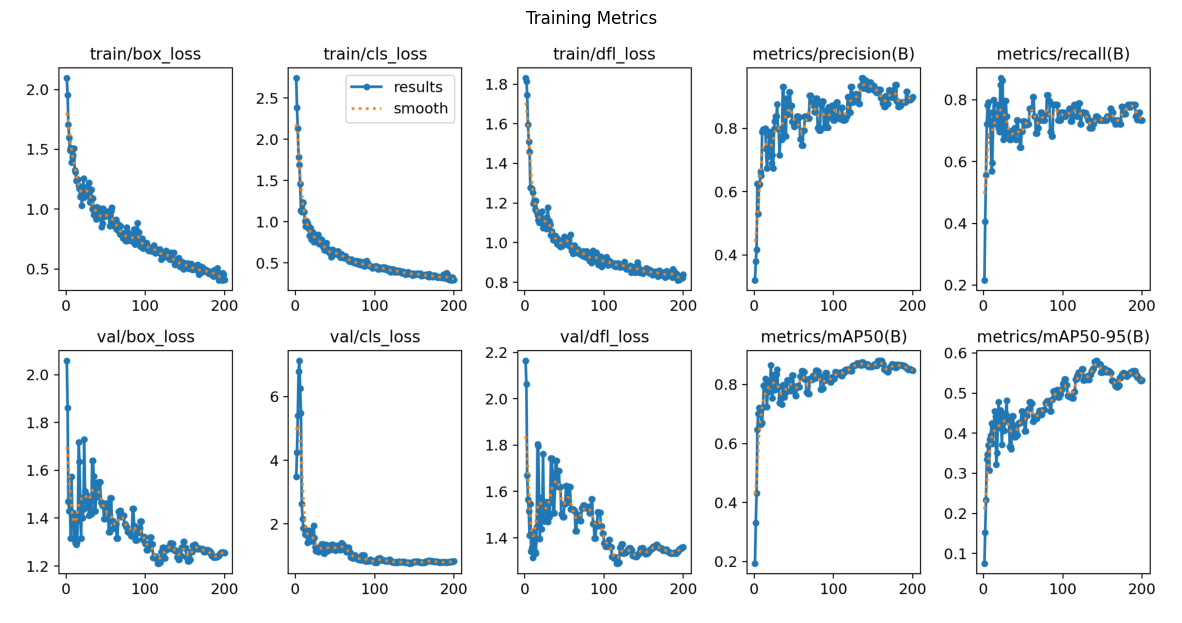

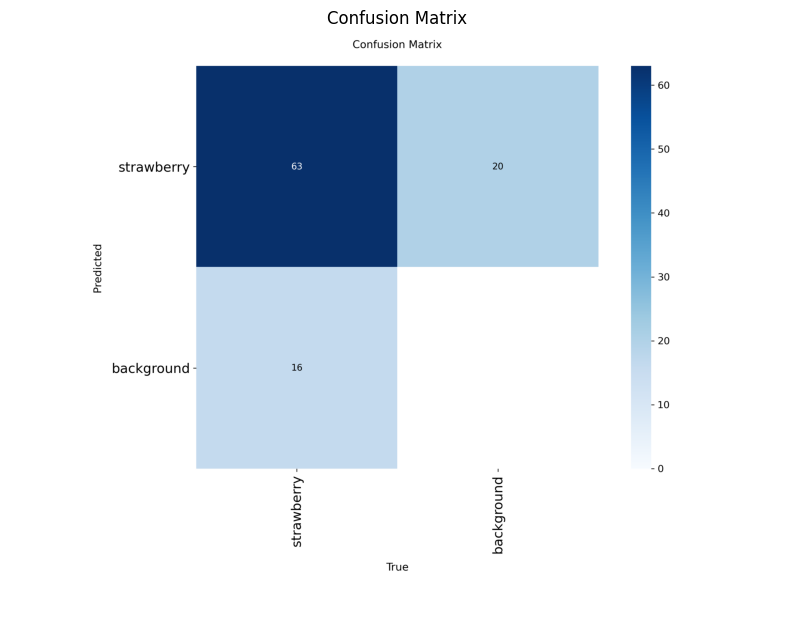

In [7]:
# Display the training results plot and confusion matrix
results_plot_path = os.path.join('output', 'train', 'results.png')
confusion_matrix_path = os.path.join('output', 'train', 'confusion_matrix.png')

if os.path.exists(results_plot_path):
    results_img = cv2.imread(results_plot_path)
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(results_img, cv2.COLOR_BGR2RGB))
    plt.title("Training Metrics")
    plt.axis('off')
    plt.show()
else:
    print(f"Could not find training results plot at {results_plot_path}")

if os.path.exists(confusion_matrix_path):
    cm_img = cv2.imread(confusion_matrix_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB))
    plt.title("Confusion Matrix")
    plt.axis('off')
    plt.show()
else:
    print(f"Could not find confusion matrix at {confusion_matrix_path}")

## 5. Inference with the Fine-Tuned Model

With our newly fine-tuned model, let's run inference on the same validation images and see the difference. We expect a significant improvement in detection accuracy.

Running fine-tuned YOLOv11 inference on images in c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val...

image 1/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val\1.png: 384x640 14 strawberrys, 113.1ms
image 2/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val\13.png: 512x640 9 strawberrys, 130.5ms
image 3/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val\14.png: 480x640 9 strawberrys, 122.8ms
image 4/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val\15.png: 480x640 6 strawberrys, 125.0ms
image 5/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val\16.png: 448x640 9 strawberrys, 135.1ms
image 6/8 c:\Users\wbrya\OneDrive\Documents\GitHub\Image-Object-Counter\strawberry_dataset\images\val\21.png: 480x640 9 strawberrys, 129.7ms
image 7/

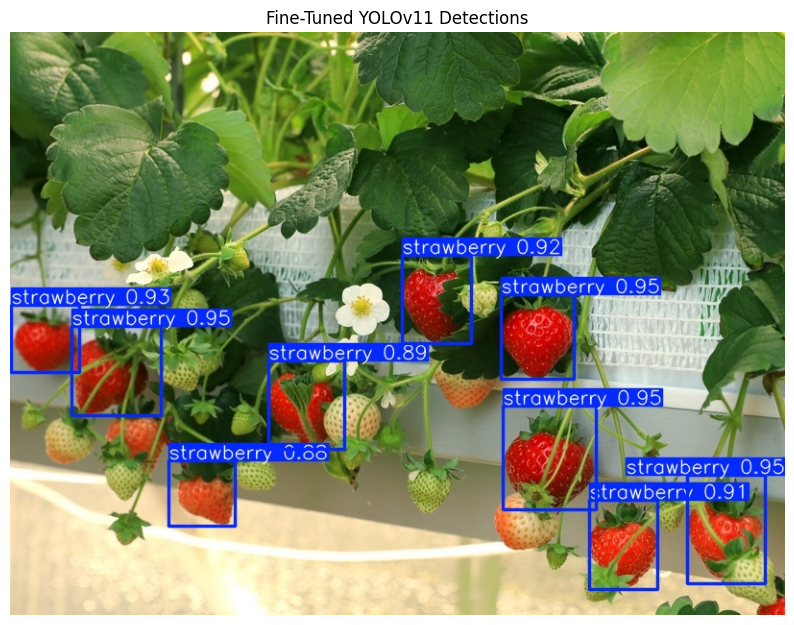

In [8]:
# Path to our best trained weights
finetuned_weights = os.path.join('output', 'train', 'weights', 'best.pt')

print(f"Running fine-tuned YOLOv11 inference on images in {val_dir}...")
# We lower the confidence threshold to see if the model is detecting anything
run_inference(finetuned_weights, val_dir, FINETUNED_OUT_DIR, conf=0.70)

# Display a sample result
finetuned_result_path = os.path.join(FINETUNED_OUT_DIR, 'predictions', '13.jpg')

# Check if the result file was created
if os.path.exists(finetuned_result_path):
    finetuned_result = cv2.imread(finetuned_result_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(finetuned_result, cv2.COLOR_BGR2RGB))
    plt.title("Fine-Tuned YOLOv11 Detections")
    plt.axis('off')
    plt.show()
else:
    print(f"Could not find result file at {finetuned_result_path}")

## Conclusion

By comparing the outputs, we can clearly see the progression:
- **OpenCV Baseline**: Fast and simple, but brittle and inaccurate.
- **Pre-trained YOLO**: Failed to detect the strawberries correctly as it wasn't trained for them.
- **Fine-tuned YOLO**: Accurately detects and localizes the strawberries after being trained on our custom dataset.

This demonstrates the power of transfer learning and fine-tuning for custom object detection tasks.